In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
using YAXArrays
using Zarr
using Dates


  Activating project at `~/workspace/uni/spatial_temporal_data/spatio_temporal_data-rainforest_development`


In [2]:
include("src/rainforest_lib.jl")
using .Rainforestlib

In [3]:
lc = Rainforestlib.get_lcc_datacube()


YAXArray with the following dimensions
lon                 Axis with 32400 Elements from -179.9986111111111 to 179.9902777777778
lat                 Axis with 16200 Elements from 89.99027777777778 to -89.99861111111112
time                Axis with 11 Elements from 2010-01-01T00:00:00 to 2020-01-01T00:00:00
name: lccs_class
Total size: 5.38 GB


In [4]:
filtered_dc = Rainforestlib.rough_spatial_filter(lc; time_bounds = (Date(2010), Date(2020)))


YAXArray with the following dimensions
lon                 Axis with 5400 Elements from -89.9986111111111 to -30.009722222222205
lat                 Axis with 4050 Elements from 14.990277777777777 to -29.99861111111111
time                Axis with 10 Elements from 2010-01-01T00:00:00 to 2019-01-01T00:00:00
name: lccs_class
Total size: 208.57 MB


In [6]:
using .Rainforestlib

# set a set of accepted values
accepted_values = Set(["tree_broadleaved_evergreen_closed_to_open"])

# WARNING: do not try this with the huge datacube, it wont work. The in function needs to be ported to datacubes, the native one is not working
# to create the world map, simply set local_map=false
# global_figure = Rainforestlib.build_figure_by_lcc_classes(lc, Set(["tree_broadleaved_evergreen_closed_to_open"]), false)

Set{String} with 1 element:
  "tree_broadleaved_evergreen_closed_to_open"

┌ Warning: Could not find font regular, using TeX Gyre Heros Makie
└ @ Makie /home/denis/.julia/packages/Makie/iECbF/src/conversions.jl:993


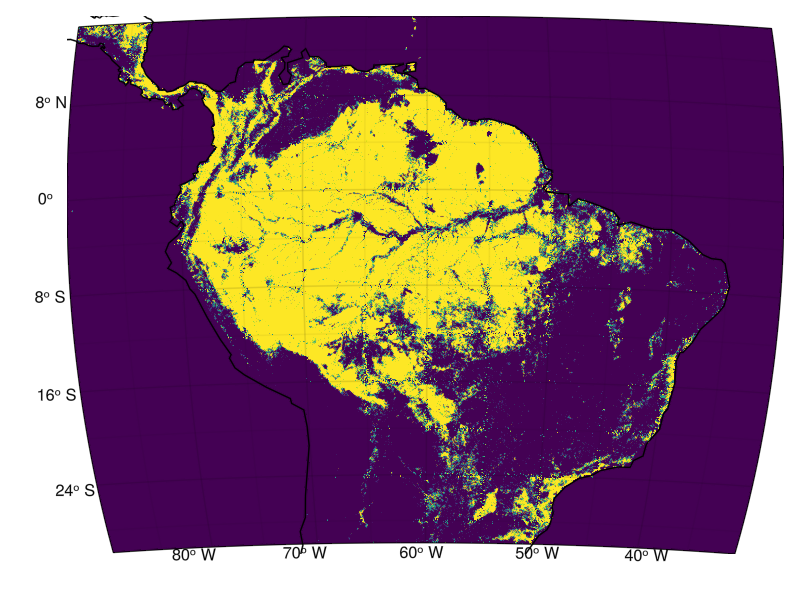

In [7]:
using .Rainforestlib

# local is the default, and makes the map as large as the datapoints
# but can me changed by setting 
local_figure = Rainforestlib.build_figure_by_lcc_classes(filtered_dc, accepted_values)

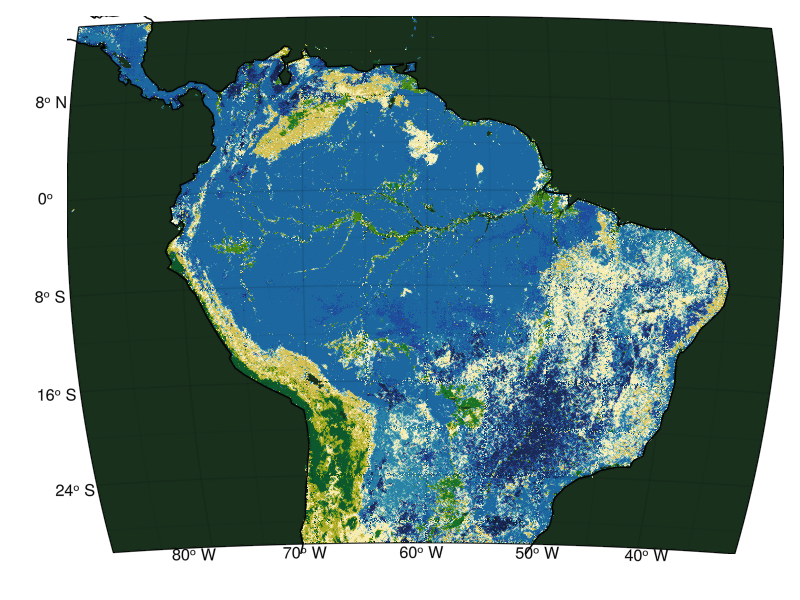

In [8]:
using .Rainforestlib

local_figure = Rainforestlib.build_figure_all_classes(filtered_dc; colormap = :delta)

In [10]:
# build one figure with diffs for each timestep
using GLMakie, .Rainforestlib

lonpadding::Float64 = 1.0 
latpadding::Float64 = 1.0

datacube = filtered_dc

timesteps = YAXArrays.getAxis("time", datacube).values
timesteps_num = size(datacube, 3)

last = 0.0

lonsize = length(YAXArrays.getAxis("lon", datacube).values)
latsize = length(YAXArrays.getAxis("lat", datacube).values)

last_bitmask = zeros(lonsize, latsize)

results = []

# 3 is the time dimension
for t in range(1, length(timesteps))
    y_val = (t % 3) + 1 
    x_val = t ÷ 3

    year = timesteps[t]

    bitmask = Rainforestlib.build_bitmask_by_lccs_class(datacube[:, :, t], accepted_values)


    diff_bitmask = Rainforestlib.Rainforestlib_utils.diff_matrices(bitmask, last_bitmask) do new, old
        if old == new
            return old
        else
            if old < new
                # this means something got added
                return 0.5
            else
                return -0.5
            end
        end
    end

    last_bitmask = bitmask

    number_of_rf_pixels = sum(filter(!isnan, bitmask))
    

    println("Number of rainforest pixels in $(year): $(number_of_rf_pixels)")
    println("Diff to last: $(number_of_rf_pixels - last)")

    last = number_of_rf_pixels

    lon = YAXArrays.getAxis("lon", datacube).values |> extrema 
    lat = YAXArrays.getAxis("lat", datacube).values |> extrema
    lonrange = range(lon[1], lon[end], size(diff_bitmask, 1))

    fig = Figure()

    # we need to flip the latitude because of an error in the datacube!!!!!
    latrange = range(lat[1], lat[end], size(diff_bitmask, 2))[end:-1:1]

    ga = Rainforestlib.local_geoaxis_creation!(fig, lon, lat; lonpadding = lonpadding, latpadding = latpadding, title = "Plot $(year)")
    surface!(ga, lonrange, latrange, diff_bitmask)

    push!(results, fig)
end

Number of rainforest pixels in 2010-01-01T00:00:00: 4.614232e6
Diff to last: 4.614232e6


┌ Warning: Could not find font regular, using TeX Gyre Heros Makie
└ @ Makie /home/denis/.julia/packages/Makie/iECbF/src/conversions.jl:993


Number of rainforest pixels in 2011-01-01T00:00:00: 4.611793e6
Diff to last: -2439.0


Number of rainforest pixels in 2012-01-01T00:00:00: 4.611263e6
Diff to last: -530.0


Number of rainforest pixels in 2013-01-01T00:00:00: 4.610353e6
Diff to last: -910.0


Number of rainforest pixels in 2014-01-01T00:00:00: 4.613331e6
Diff to last: 2978.0


Number of rainforest pixels in 2015-01-01T00:00:00: 4.613325e6
Diff to last: -6.0


Number of rainforest pixels in 2016-01-01T00:00:00: 4.615178e6
Diff to last: 1853.0


Number of rainforest pixels in 2017-01-01T00:00:00: 4.61473e6
Diff to last: -448.0


Number of rainforest pixels in 2018-01-01T00:00:00: 4.613133e6
Diff to last: -1597.0


Number of rainforest pixels in 2019-01-01T00:00:00: 4.614627e6
Diff to last: 1494.0


In [ ]:
using GLMakie
for (index, figure) in enumerate(results)
    save("fig_$(index).png", figure)
end